In [1]:
import math
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
from ecell4 import *
rng = GSLRandomNumberGenerator()
#from ecell4.gillespie import GillespieWorld as world_type, GillespieSimulator as simulator_type

In [2]:
@species_attributes
def attrgen(radius, D):
    K | {"radius": radius, "D": D}
    Kp | {"radius": radius, "D": D}
    Kpp | {"radius": radius, "D": D}
    KK | {"radius": radius, "D": D}
    PP | {"radius": radius, "D": D}
    K_KK | {"radius": radius, "D": D}
    Kp_KK | {"radius": radius, "D": D}
    Kpp_PP | {"radius": radius, "D": D}
    Kp_PP | {"radius": radius, "D": D}
    C | {"radius": radius, "D": D}

@reaction_rules
def rulegen(kon1, koff1, kcat1, kon2, koff2, kcat2,k7):
    (KK + K == K_KK | (kon1, koff1)
        > Kp + KKa | kcat1)
    (KK + Kp == Kp_KK | (kon2, koff2)
        > Kpp + KKa | kcat2)
    (KKa > KK | k7)
    (Kpp + PP == Kpp_PP | (kon1, koff1)
        > Kp + PPa | kcat1)     
    (Kp + PP == Kp_PP | (kon2, koff2)
        > K + PPa | kcat2)
    (PPa > PP | k7)

@reaction_rules    
def rulegen2(kon1, koff1, kcat1, kcat2):
    (K + KK == K_KK | (kon1, koff1)
        > Kp_KK | kcat1
        > Kpp + KK | kcat2)

    (Kpp + PP == Kpp_PP | (kon1, koff1)
        > Kp + PP | kcat1
        > K + PP | kcat2)
 

In [3]:
#rulegen(ka1, kd1, kcat1, ka2, kd2, kcat2,k7)
ka1, kd1, kcat1 = 0.04483455086786913, 1.35, 1.5
ka2, kd2, kcat2 = 0.09299017957780264, 1.73, 15.0
trel = 1e-5
k7 = math.log(2)/trel
radius = 0.0025

In [4]:
def run(ratio,m):
    voxelr = 1.0208582*radius
    w = spatiocyte.SpatiocyteWorld(Real3(1, 1, 1),voxelr,rng)
    (c,r,l)=w.shape()
    Nev=(c - 2) * (r - 2) * (l - 2)
    w.bind_to(m)
    w.add_molecules(Species("K"), NKT)
    npp = int(60./(ratio+1))
    nkk = 60-npp
    w.add_molecules(Species("KK"), nkk)
    w.add_molecules(Species("PP"), npp)
    Nt=nkk+npp+NKT
    phil = 0.15*0.74/0.515
    Nc = int(Nev*phil)-Nt
    w.add_molecules(Species("C"), Nc)
    sim = spatiocyte.SpatiocyteSimulator(m, w)
    obs = FixedIntervalNumberObserver(1.0, ["KK","Kpp","PP"])
    sim.run(dur, [obs])
    data = np.array(obs.data()).T
    NKK = data[1]
    NKpp = data[2]
    NP = data[3]
    tt = data[0]
    return tt,NKK,NKpp,NP

def run_gil(ratio,m):
    w = ode.ODEWorld(Real3(1, 1, 1))#world_type(Real3(1, 1, 1))
    w.bind_to(m)
    w.add_molecules(Species("K"), NKT)
    npp = int(60./(ratio+1))
    nkk = 60-npp
    w.add_molecules(Species("KK"), nkk)
    w.add_molecules(Species("PP"), npp)
    sim = ode.ODESimulator(m,w)#simulator_type(m, w)
    obs = FixedIntervalNumberObserver(1.0, ["KK","Kpp","PP"])
    sim.run(dur, [obs])
    data = np.array(obs.data()).T
    NKK = data[1]
    NKpp = data[2]
    NP = data[3]
    tt = data[0]
    return tt,NKK,NKpp,NP

In [ ]:
ratios = [5.]#np.logspace(-1.5,1.5,50)
NKT = 120
dur = 200#1000

for D in [4.]:
    m = NetworkModel()
    voxelr = 1.0208582*radius
    for i, sp in enumerate(attrgen(str(voxelr), str(D))):
        #print(i, sp.serial(), sp.get_attribute("radius"), sp.get_attribute("D"))
        m.add_species_attribute(sp)
    rul = rulegen(ka1, kd1, kcat1, ka2, kd2, kcat2,k7)
    for i, rr in enumerate(rul):
        reactants, products, k = rr.reactants(), rr.products(), rr.k()
        #print(i, rr.as_string())
        m.add_reaction_rule(rr)
    xx = []
    yy = []    
    for ratio in ratios:
        tt,NKK,NKpp,NP = run(ratio,m)
        xx.append(ratio)# np.mean(NKK[int(dur*0.5):])/np.mean(NP[int(dur*0.5):]))
        yy.append(np.mean(NKpp[int(dur*0.5):])/NKT)
        plotts(tt,NKK,NP,NKpp)
    #plt.semilogx(xx,yy,'-',label=lab)
#plt.ylim(0,1)
#plt.xlim(0.01,100)
#plt.legend(loc='best')
xx,yy

In [ ]:
plt.plot(tt,NKK)
plt.plot(tt,NP)
plt.plot(tt,NKpp)
xx,yy

In [14]:
ratios = np.logspace(-1.5,1.5,100)
NKT = 120
dur = 200#1000
#D = 1
xx = [[],[]]
yy = [[],[]]  
for cnt in range(2) :
    if cnt==0: D = 4.
    else: D = 0.06
    m = NetworkModel()
    for i, sp in enumerate(attrgen(str(radius), str(D))):
        #print(i, sp.serial(), sp.get_attribute("radius"), sp.get_attribute("D"))
        m.add_species_attribute(sp)
    def kon(k):
        kD = 4*3.14*2*radius*2*D
        #k = k*(k/(k+kD))
        return k*kD/(k+kD)
    def koff(kd,ka):
        return kon(ka)*kd/ka 
    if cnt==0:
    #rul = rulegen(ka1, kd2, kcat1, ka2, kd2, kcat2,k7)
        rul = rulegen(kon(ka1), koff(kd1,ka1), kcat1, kon(ka2), koff(kd2,ka2), kcat2,k7)    
        lab = 'distributive'
    else:
        rul = rulegen2(kon(ka1), koff(kd1,ka1), kcat1, kcat2)    
        lab = 'processive'
    for i, rr in enumerate(rul):
        reactants, products, k = rr.reactants(), rr.products(), rr.k()
        #print(i, rr.as_string())
        m.add_reaction_rule(rr)
  
    for ratio in ratios:
        tt,NKK,NKpp,NP = run_gil(ratio,m)
        xx[cnt].append(ratio)# np.mean(NKK[int(dur*0.5):])/np.mean(NP[int(dur*0.5):]))
        yy[cnt].append(np.mean(NKpp[int(dur*0.5):])/NKT)
        #plotts(tt,NKK,NP,NKpp)
    #plt.semilogx(xx,yy,'.-',label=lab)



0.06
gx
4.0
g*


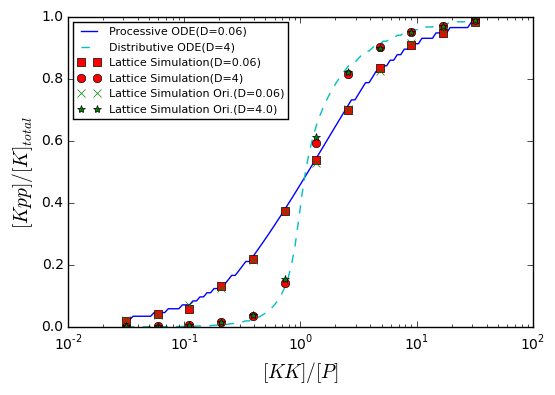

In [121]:
#plt.semilogx(xx[1],yy[1],'b-',label='Processive ODE(D=0.06)')
plt.semilogx(xx[0],yy[0],'c--',label='Distributive ODE(D=4)')
#plt.semilogx(0.5,0.0633,'o',label='spa,D=4,trel=1e-6')   
#plt.semilogx(0.5,0.258,'co',label='spa,D=0.06,trel=1e-6')   
#plotspa("data/mapk_D0.06/")
#plotspa("data/mapk_D4/")
#plotspa("data/mapk_sc_D0.060/")
plotspa("data/mapk_sc_D4.000/")
#plotspa2("data/mapk_D0.06/")
plotspa2("data/mapk_D4/")
#plt.semilogx(0.5,0.16,'ks',label='spa,D=0.06,trel=1e-3')
#plt.semilogx(0.5,0.272,'ys',label='spa,D=0.06,trel=1e-9')
#plt.semilogx(0.5,0.266,'bs',label='spa,D=0.06,trel=1e-5')   
plt.ylim(0,1)
plt.xlim(0.01,100)
plt.xlabel('$[KK]/[P]$',fontsize=14)
plt.ylabel('$[Kpp]/[K]_{total}$',fontsize=14)
plt.legend(loc='best',fontsize=8)
#plt.savefig("figure/mapk.png",format='png',dpi=300)    

In [17]:
def plotts(tt,NKK,NP,NKpp):
    plt.plot(tt, NKK, "r-", label="KK")
    plt.plot(tt,NP , "g--", label="P")
    plt.plot(tt, NKpp, "b:", label="Kpp")
    plt.xlabel("Time")
    plt.ylabel("Number Of Molecules")
    #plt.xlim(data[0][0], data[0][-1])
    plt.legend(loc="best", shadow=True)
    #plt.savefig("figure/MAPKmodel1.png",format='png',dpi=100)  

In [116]:
def plotspa(name):
    names = os.listdir(name)
    lst = []
    for n in names:
        dat = np.loadtxt(name+n)
        lst.append(dat)
    lst = np.sort(lst,axis=0)    
    if float(name[14:-2])-int(float(name[14:-2]))==0:
        nam = str(int(float(name[14:-2])))
        c='ro'
    else: 
        nam = str(name[14:-2])
        c='rs'
    plt.semilogx(lst[:,0],lst[:,1],c,label='Lattice Simulation(D='+nam+')')
    plt.legend()
    
def plotspa2(name):
    names = os.listdir(name)
    lst = []
    for n in names:
        dat = np.loadtxt(name+n)
        lst.append(dat)
    nam= float(name[11:-1])
    print nam
    if nam==0.06:
        c='gx'
    else: 
        c='g*'
    print c
    lst = np.sort(lst,axis=0)    
    plt.semilogx(lst[:,0],lst[:,1],c,label='Lattice Simulation Ori.(D='+str(nam)+')')
    plt.legend()    

0.06
rx


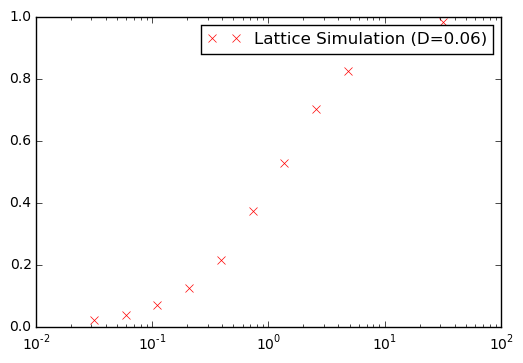

In [105]:
plotspa2("data/mapk_D0.06/")
#plotspa2("data/mapk_D4/")
#plotspa("data/mapk_sc_D4.000/")

In [28]:
np.sort(lst,axis=0)

array([[ 1,  2],
       [ 2, 50]])

In [2]:
import numpy as np
np.logspace(-1.5,1.5,12)

array([  0.03162278,   0.05925531,   0.11103363,   0.20805675,
         0.38986037,   0.73052715,   1.36887451,   2.56502091,
         4.80638086,   9.0062802 ,  16.87612476,  31.6227766 ])